In [1]:
from rdkit.Chem.rdmolfiles import MolFromPDBFile
from rdkit.Chem.rdchem import Mol
from rdkit.Chem import AllChem

import numpy as np
import rdkit.Chem as Chem
from rdkit.Chem import AddHs, AssignStereochemistry, HybridizationType, ChiralType, BondStereo, MolFromMol2File
from rdkit.Chem.AllChem import ComputeGasteigerCharges
import os
import sys
sys.path.append("../../")
from src.utils.constants import ES_THRESHOLD, METAL_OX_STATES, POCKET_THRESHOLD
from tqdm import tqdm 

In [2]:
from src.data.utils import pdb_to_rdkit_mol, mol2_to_rdkit_mol
from src.data.pocket_utils import combine_and_filter, remove_waters

In [3]:
from time import time
import os
from tqdm import tqdm
from rdkit import Chem
from contextlib import contextmanager

@contextmanager
def time_block(label):
    start = time()
    try:
        yield
    finally:
        end = time()
        print(f"{label}: {end - start:.2f} seconds")


In [4]:
# Example usage:
ligand_mol2_path = '../../test_data/pdb/1a0q/1a0q_ligand.mol2'
protein_pdb_path = '../../test_data/pdb/1a0q/1a0q_protein.pdb'
constant_distance = 5.0  # Example constant distance in angstroms

ligand_mol = mol2_to_rdkit_mol(ligand_mol2_path)
protein_mol = pdb_to_rdkit_mol(protein_pdb_path)

In [5]:
# Set by_residue to True to include entire residues
pocket_mol_res = combine_and_filter(ligand_mol, remove_waters(protein_mol), by_residue=True)

# To save the resulting complex_mol to a PDB file:
output_path =  '../../test_data/pdb/1a0q/pocket_mol_res.pdb'
pdb_block = Chem.MolToPDBBlock(pocket_mol_res)

with open(output_path, 'w') as file:
    file.write(pdb_block)


Getting ligand centroid: 0.00 seconds
Calculating max distance: 0.02 seconds
Getting conformer: 0.00 seconds
Getting atom positions: 0.00 seconds
Matrix operations: 0.00 seconds
Grouping by residue: 0.01 seconds
Calculating atom positions: 0.01 seconds
Getting atoms within distance: 0.01 seconds
Filtering atoms: 0.21 seconds
Combining molecules: 0.00 seconds
Tagging atoms: 0.00 seconds
Combining molecules: 0.00 seconds


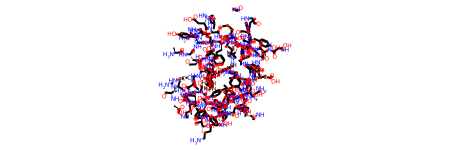

In [6]:
pocket_mol_res


Getting ligand centroid: 0.00 seconds
Calculating max distance: 0.03 seconds
Getting conformer: 0.00 seconds
Getting atom positions: 0.00 seconds
Matrix operations: 0.00 seconds
Grouping by residue: 0.00 seconds
Calculating atom positions: 0.00 seconds
Getting atoms within distance: 0.00 seconds
Filtering atoms: 0.16 seconds
Combining molecules: 0.00 seconds
Tagging atoms: 0.00 seconds
Combining molecules: 0.00 seconds


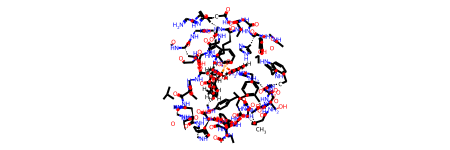

In [7]:
pocket_mol_atom = combine_and_filter(ligand_mol, protein_mol, constant_distance, by_residue=False)
pocket_mol_atom